In [ ]:
#| default_exp utility

In [30]:
#| export
from dji_thermal_sdk.dji_sdk import *
import dji_thermal_sdk.dji_sdk as DJI
import numpy as np
import exif
import os
import ctypes as CT
from ctypes import *

In [43]:
#| hide
import matplotlib.pyplot as plt

In [33]:
#| export
class str2(str):
    def __repr__(self):
        # Allow str.__repr__() to do the hard work, then
        # remove the outer two characters, single quotes,
        # and replace them with double quotes.
        return ''.join(('', super().__repr__()[1:-1], ''))
def lht_parse_djixmp(file_path:str):
    with open(file_path,'rb') as fd:
        d = fd.read()
        d = str(d)
        xmp_start = d.find('<x:xmpmeta')
        xmp_end = d.find('</x:xmpmeta')
        if xmp_start != xmp_end:
            xmp_str = d[xmp_start:xmp_end+12]

    xmp_dict = {}
    xmp_str = xmp_str.strip()
    a = xmp_str.split('\\n')
    b = filter(lambda x: 'drone-dji' in x and 'xmlns' not in x, a)
    b = [i.strip() for i in b]
    b = [str2(i) for i in b]
    for j in b:
        try:
            k = j.split('=')[0]
            v = np.float32(j.split('=')[1].replace('"', ''))
            xmp_dict[k] = v
        except ValueError:
            continue
    #
    return xmp_dict
#
def getJPEGHandle(file_path):
    '''
    parameters:
        [str] file_path: jpg file
    return:
        DIRP_HANDLE
    '''
    rd = file_path
    with open(rd, 'rb') as f:
        content = f.read()
    # method1 to get the file size
    #print(f"File size: {os.path.getsize(rd)}")
    # method 2 to get the file size
    file_stat = os.stat(rd)
    size = c_int32(file_stat.st_size)
    # the method to create a string buffer, which is important.
    rjpeg_data = CT.create_string_buffer(len(content))
    rjpeg_data.value = content
    # test the function to create a handle of an image
    ret = dirp_create_from_rjpeg(rjpeg_data,size, CT.byref(DIRP_HANDLE))
    return ret
    pass

In [55]:
#| export
def rjpeg_to_thermal(src:str, palette:int):
    '''
    parameters:
        [str] src: file path of original jpg. For example, c:\\deer.jpg
        [int] palette: the number of palette
                - DIRP_PSEUDO_COLOR_WHITEHOT   = 0
                - DIRP_PSEUDO_COLOR_FULGURITE  = 1
                - DIRP_PSEUDO_COLOR_IRONRED    = 2
                - DIRP_PSEUDO_COLOR_HOTIRON    = 3
                - DIRP_PSEUDO_COLOR_MEDICAL    = 4
                - DIRP_PSEUDO_COLOR_ARCTIC     = 5
                - DIRP_PSEUDO_COLOR_RAINBOW1   = 6
                - DIRP_PSEUDO_COLOR_RAINBOW2   = 7
                - DIRP_PSEUDO_COLOR_TINT       = 8
                - DIRP_PSEUDO_COLOR_BLACKHOT   = 9
    return:
        return numpy.ndarray -> img
    '''
    ret = getJPEGHandle(src)
    if ret != 0:
        raise ValueError(f"the rjpg file:{src} is not from DJI device")
    # read binary data
    with open(src, 'rb') as f:
        ex = exif.Image(f)
    if hasattr(ex, 'make'):
        if ex.make != "DJI":
            raise ValueError(f"Warning: the file comes from {ex.make}, which is not DJI product.")
    else:
        raise ValueError("Warning: the file comes from unknown device.")
    # Configure palette
    palette = c_int(palette)
    ret = dirp_set_pseudo_color(DIRP_HANDLE, palette)
    rjpeg_resolution = dirp_resolution_t()
    ret = dirp_get_rjpeg_resolution(DIRP_HANDLE, CT.byref(rjpeg_resolution))
    #
    img_h = rjpeg_resolution.height
    img_w = rjpeg_resolution.width
    size = rjpeg_resolution.height * rjpeg_resolution.width * 3 * CT.sizeof(c_uint8)
    raw_image_buffer = CT.create_string_buffer(size)
    #
    #
    ret = dirp_process(DIRP_HANDLE,byref(raw_image_buffer), size)
    if ret != DIRP_SUCCESS:
        raise ValueError("Fail to generate .raw file.")
    #
    raw_file_path = os.path.splitext(src)[0] + ".raw"
    #
    with open(raw_file_path, 'wb') as f:
        f.write(raw_image_buffer.raw)
    with open(raw_file_path, encoding='cp1252') as fin:
        img = np.fromfile(fin, dtype = np.uint8)
        img.shape = (img_h,img_w,3)
    # delete .raw file
    os.remove(raw_file_path)
    return img

In [56]:
#| export
def rjpeg_to_heatmap(src:str,dtype='float32'):
    '''
    parameters:
        [str] src: file path of original jpg. For example, c:\\deer.jpg
        [str] dtype: 'float32' or 'int16'
    return:
        return numpy.ndarray -> img
    '''
    ret = getJPEGHandle(src)
    if ret != 0:
        raise ValueError(f"the rjpg file:{src} is not from DJI device")
    rjpeg_resolution = DJI.dirp_resolution_t()
    DJI.dirp_get_rjpeg_resolution(DJI.DIRP_HANDLE, CT.byref(rjpeg_resolution))
    img_h = rjpeg_resolution.height
    img_w = rjpeg_resolution.width
    # calculate the buffer size based on the resolution
    if dtype == 'int16':
        size = rjpeg_resolution.height * rjpeg_resolution.width *  CT.sizeof(CT.c_int16)
        # create a buffer for a raw image
        raw_image_buffer = CT.create_string_buffer(size)
        ret = DJI.dirp_measure(DJI.DIRP_HANDLE, CT.byref(raw_image_buffer), size)
        if ret != DJI.DIRP_SUCCESS:
            raise ValueError(f"Error: error code={ret}")
        raw_file_path = os.path.splitext(src)[0] + ".raw"
        with open(raw_file_path, 'wb') as f:
            f.write(raw_image_buffer.raw)
        with open(raw_file_path, encoding='cp1252') as fin:
            img = np.fromfile(fin, dtype = np.int16)
            img.shape = (img_h,img_w)
    else:
        size = rjpeg_resolution.height * rjpeg_resolution.width *  CT.sizeof(CT.c_float)
        # create a buffer for a raw image
        raw_image_buffer = CT.create_string_buffer(size)
        ret = DJI.dirp_measure_ex(DJI.DIRP_HANDLE, CT.byref(raw_image_buffer), size)
        if ret != DJI.DIRP_SUCCESS:
            raise ValueError(f"Error: error code={ret}")
        raw_file_path = os.path.splitext(src)[0] + ".raw"
        with open(raw_file_path, 'wb') as f:
            f.write(raw_image_buffer.raw)
        with open(raw_file_path, encoding='cp1252') as fin:
            img = np.fromfile(fin, dtype = np.float32)
            img.shape = (img_h,img_w)
    # delete .raw file
    os.remove(raw_file_path)
    return img

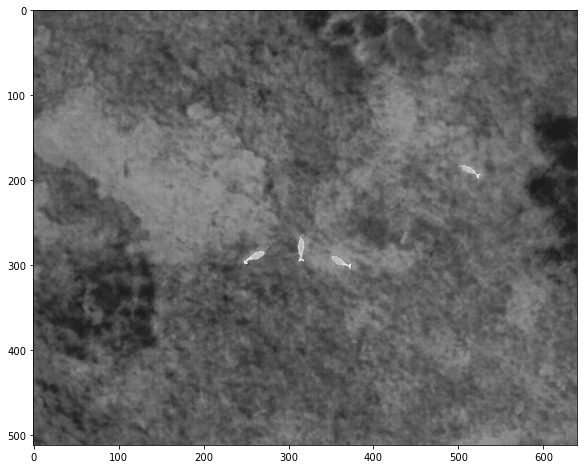

In [59]:
#| hide
src = r"dataset\Deer_Goats_Unsure.jpg"
des = r"dataset\0.jpg"
img = rjpeg_to_thermal(src,0)
fig = plt.figure(figsize=(10,8))
plt.imshow(img)

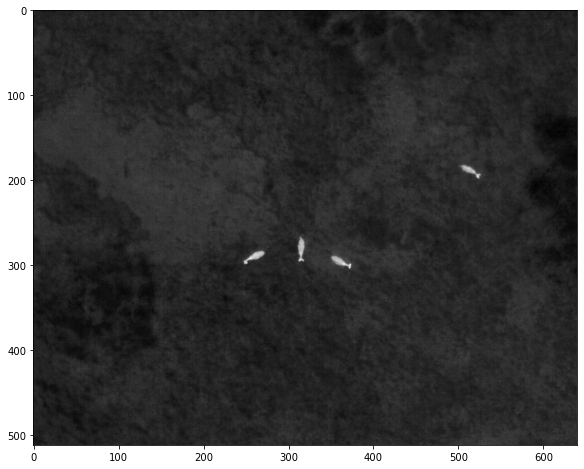

In [60]:
#| hide
src = r"dataset\Deer_Goats_Unsure.jpg"
des = r"dataset\0.jpg"
img = rjpeg_to_heatmap(src,dtype='float32')
fig = plt.figure(figsize=(10,8))
plt.imshow(img, cmap='gray')

In [47]:
#| hide
getJPEGHandle(r"dataset\cat.jpg")

-7

In [13]:
#| hide
rd = r"dataset\Deer_Goats_Unsure.jpg"
lht_parse_djixmp(rd)

{'drone-dji:GpsLatitude': 27.588604,
 'drone-dji:GpsLongitude': 84.46672,
 'drone-dji:AbsoluteAltitude': 153.5,
 'drone-dji:RelativeAltitude': 30.68,
 'drone-dji:GimbalRollDegree': 0.0,
 'drone-dji:GimbalYawDegree': 50.4,
 'drone-dji:GimbalPitchDegree': -89.9,
 'drone-dji:FlightRollDegree': -0.2,
 'drone-dji:FlightYawDegree': 53.3,
 'drone-dji:FlightPitchDegree': 0.0,
 'drone-dji:CamReverse': 0.0,
 'drone-dji:GimbalReverse': 0.0}

In [39]:
#| hide
rd = r"dataset\Deer_Goats_Unsure.jpg"
with open(rd,'rb') as image_file:
    ex = exif.Image(image_file)
ex.has_exif

hasattr(ex,'make')